In [1]:
!nvidia-smi

Sun Dec 29 16:56:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    On  | 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8               2W / 140W |    421MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
def mul(*v):
    ret=1
    for x in v:
        ret*=x
    return ret

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from tqdm import tqdm

from torchsummary import summary
from matplotlib import pyplot as plt
import numpy as np
import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
l = torchvision.datasets.MNIST(root='./mnist_data/', train = True, download = True, transform = transforms.ToTensor())
t = torchvision.datasets.MNIST(root='./mnist_data/', train = False, download = True, transform = transforms.ToTensor())

In [5]:
l.data.shape,l.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [6]:
l.data[0].shape,l.targets[0]

(torch.Size([28, 28]), tensor(5))

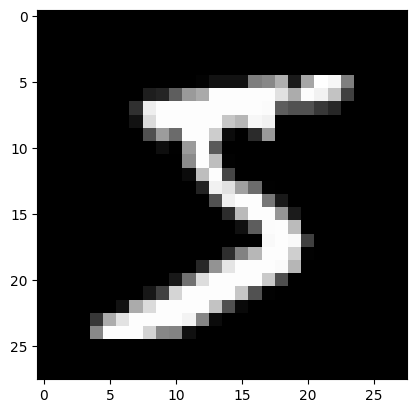

In [7]:
plt.imshow(l.data[0].numpy(), cmap='gray') 

In [8]:
x_l=l.data.numpy()
y_l=l.targets.numpy()
x_t=t.data.numpy()
y_t=t.targets.numpy()

In [9]:
'''
take first NUM_SIZE of imgs for each num
'''
L_NUM_SIZE=1000
count=np.zeros(10)
idx=[]
for i,num in enumerate(y_l):
    for j in range(10): #0~9 all imgs
        if num==j:
            count[j]+=1 #count each num in the training set
            if count[j]<=L_NUM_SIZE:
                idx.append(i)

idx=np.array(idx)


In [10]:
IMG_SIZE=(14,14)
IMG_DTYPE=np.float32
COLOR_THRESHOLD=128

img_dim=mul(*IMG_SIZE)

#training set
yl=y_l[idx] #get selected imgs

xl=np.zeros([L_NUM_SIZE*10,*IMG_SIZE]).astype(IMG_DTYPE) #get an array that fit the data and uses the correct dtype
for i,img in enumerate(x_l[idx]):
    xl[i]=np.where( #make img 0 and 1 only
        cv2.resize( #resize img
            img,IMG_SIZE
        ) > COLOR_THRESHOLD,
        1,0
    )


#testing set
T_SIZE=1000
yt=y_t[:T_SIZE]

xt=np.zeros([T_SIZE,*IMG_SIZE]).astype(IMG_DTYPE)
for i,img in enumerate(x_t[:T_SIZE]):
    xt[i]=np.where(
        cv2.resize(
            img,IMG_SIZE
        ) > COLOR_THRESHOLD,
        1,0
    )

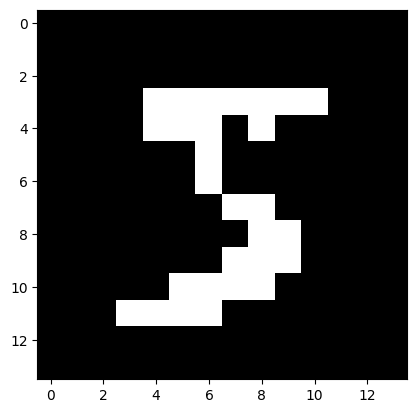

In [11]:
plt.imshow(xl[0], cmap='gray') 

In [12]:
L_BATCH_SIZE=32
T_BATCH_SIZE=100


#create dataloaders
ld=torch.utils.data.DataLoader(
    list(zip(xl,yl)),shuffle=True,batch_size=L_BATCH_SIZE
)
td=torch.utils.data.DataLoader(
    list(zip(xt,yt)),shuffle=True,batch_size=T_BATCH_SIZE
)

In [13]:
Z_DIM=8
MID_DIM=128

#for this setup: 196 -> 128 -> 8 -> 128 -> 196
#img = a point in h*w(*color) dim space

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(img_dim, MID_DIM) #Encoder
        self.fc21 = nn.Linear(MID_DIM, Z_DIM) #mu
        self.fc22 = nn.Linear(MID_DIM, Z_DIM) #sigma

        self.fc3 = nn.Linear(Z_DIM, MID_DIM) #Decoder
        self.fc4 = nn.Linear(MID_DIM, img_dim)
        
    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        return self.fc21(h), self.fc22(h) # mu, std
    
    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h)) 
    
    def forward(self, x):
        mu, std = self.encoder(x.view(-1, img_dim)) #flatten

        e1=torch.randn_like(std)
        e2=torch.randn_like(std)
        z = mu+std*(e1+e2)*0.5
        
        return self.decoder(z), mu, std

In [14]:
def loss_fn(y, x, mu, std): 
    '''BCE + KLD'''
    return F.binary_cross_entropy(y, x.view(-1, img_dim), reduction='sum') + \
        torch.sum(1 + torch.log(std**2) - mu**2 - std**2)* -0.5

In [15]:
model=VAE().to(device)
op=torch.optim.Adam(
    model.parameters(),
    lr=0.002
)

In [16]:
model

VAE(
  (fc1): Linear(in_features=196, out_features=128, bias=True)
  (fc21): Linear(in_features=128, out_features=8, bias=True)
  (fc22): Linear(in_features=128, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=196, bias=True)
)

In [17]:
def l_step(
    model: torch.nn.Module,
    dl: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    op: torch.optim.Optimizer,
    epochs:int=50
):
    # Put model in train mode
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx,(x,_) in enumerate(dl):
            x=x.to(device)

            # 1. Forward pass
            y,mu,std = model(x)

            # 2. Caculate the loss
            loss=loss_fn(y,x,mu,std)

            # 3. Optimizer zero grad
            op.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            op.step()

            epoch_loss+=loss.item()
        
        if epoch%4==0:
            print(epoch_loss)
            
    model.eval()


In [18]:
l_step(
    model,
    ld,
    loss_fn,
    op,
    100
)

520304.13775634766
356741.2670288086
340756.05194091797
331709.6969909668
326013.56481933594
322678.8666381836
318548.5367126465
316674.9764404297
314245.59478759766
313166.77713012695
311395.6617126465
310125.26403808594
308893.7844238281
308883.22186279297
308062.8678894043
306764.83361816406
306196.5369567871
305945.34591674805
304968.96908569336
304471.4583129883
303980.33752441406
303729.53143310547
303370.1037597656
303047.17126464844
302629.15731811523


In [24]:
model.decoder(torch.randn(Z_DIM).to(device)).cpu().detach().numpy()

array([3.5840384e-13, 2.6748452e-13, 2.5158250e-13, 2.2021991e-13,
       2.0146975e-13, 2.5219025e-13, 2.4222066e-13, 2.3619344e-13,
       1.4937160e-13, 2.0869219e-13, 2.5406305e-13, 2.4395470e-13,
       1.8620542e-13, 1.9917687e-13, 2.2983788e-13, 2.2874015e-13,
       2.0605911e-13, 3.2556762e-13, 8.5589910e-11, 9.4099981e-09,
       5.6656813e-07, 9.5181338e-07, 3.1150455e-07, 3.8812309e-06,
       3.8372355e-07, 9.9742241e-09, 3.6600012e-13, 3.0711273e-13,
       1.9879430e-13, 3.1603580e-13, 4.4761839e-09, 4.9880970e-07,
       6.8795174e-08, 6.0981224e-06, 6.9407841e-05, 7.6168211e-04,
       1.0016641e-03, 1.0199036e-03, 6.7711901e-04, 3.8423615e-03,
       2.2835990e-05, 3.2615124e-13, 2.1414583e-13, 1.7470374e-13,
       5.5007834e-09, 5.2004503e-07, 1.5877681e-04, 2.7280010e-03,
       1.6260511e-01, 6.5685272e-01, 9.0128815e-01, 8.6894608e-01,
       5.9706008e-01, 3.0111730e-01, 3.3681810e-02, 1.4019970e-06,
       1.3804978e-09, 5.3904927e-08, 2.4308915e-07, 1.0021430e

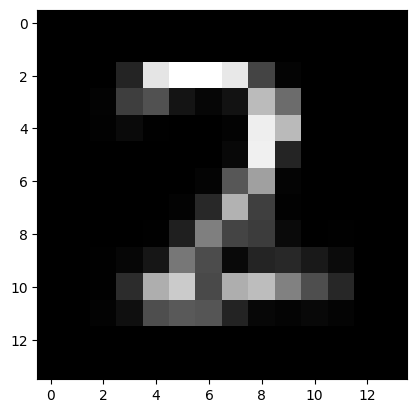

In [25]:
plt.imshow(model.decoder(torch.randn(Z_DIM).to(device)).cpu().view(*IMG_SIZE).detach().numpy(), cmap='gray') 